### 1 Laden Sie die Trainingsdaten

In [82]:
import pandas as pd

# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', 1000)


In [83]:
df_raw_transaction_data = pd.read_csv(r"data/train.csv", delimiter=';')
print(df_raw_transaction_data.head())

   transactionId                 basket customerType  totalAmount  returnLabel
0     9534310106              [4, 3, 4]          new        252.0            1
1     7202594767        [4, 2, 0, 2, 5]     existing         70.0            0
2     2737331698                    [5]     existing         84.0            0
3     4868011733           [1, 4, 2, 4]     existing        116.0            0
4     7622406570  [2, 5, 3, 2, 3, 2, 0]     existing        378.0            0


### 2 EDA

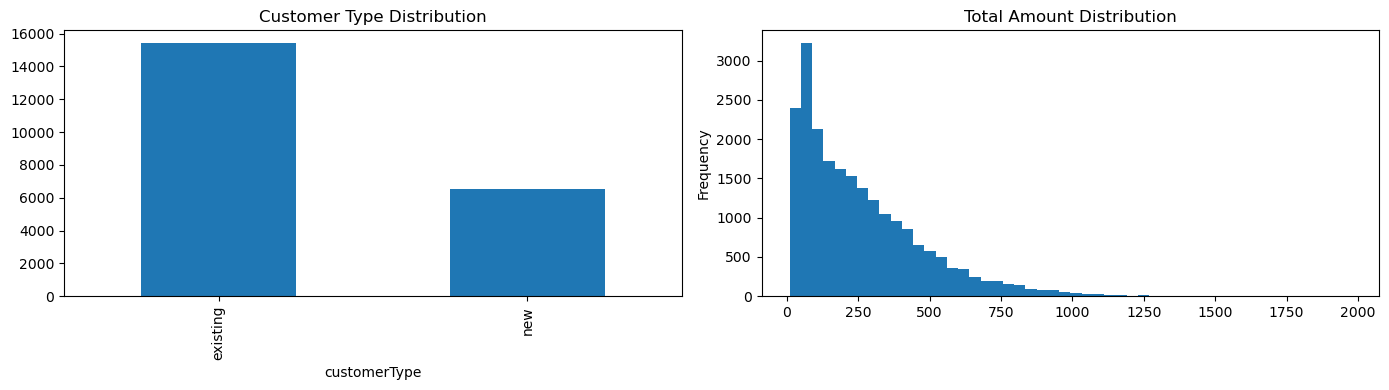

In [84]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
df_raw_transaction_data['customerType'].value_counts().plot(kind='bar', ax=axes[0], title='Customer Type Distribution')
df_raw_transaction_data['totalAmount'].plot(kind='hist', bins=50, ax=axes[1], title='Total Amount Distribution')
plt.tight_layout()
plt.show()


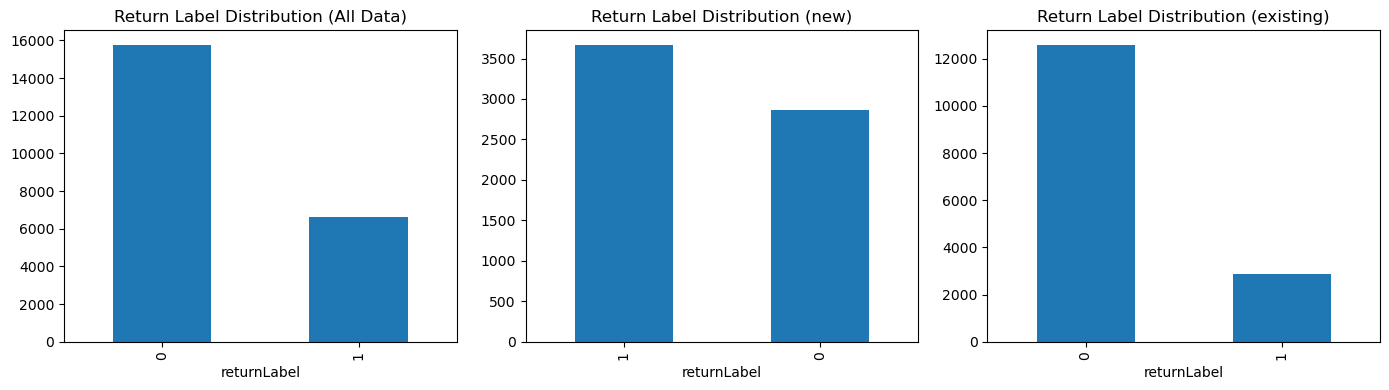

In [85]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
df_raw_transaction_data['returnLabel'].value_counts().plot(kind='bar', ax=axes[0], title='Return Label Distribution (All Data)')

subset = df_raw_transaction_data[df_raw_transaction_data['customerType'] == 'new']
subset['returnLabel'].value_counts().plot(kind='bar', ax=axes[1], title=f'Return Label Distribution (new)')
subset = df_raw_transaction_data[df_raw_transaction_data['customerType'] == 'existing']
subset['returnLabel'].value_counts().plot(kind='bar', ax=axes[2], title=f'Return Label Distribution (existing)')
plt.tight_layout()
plt.show()

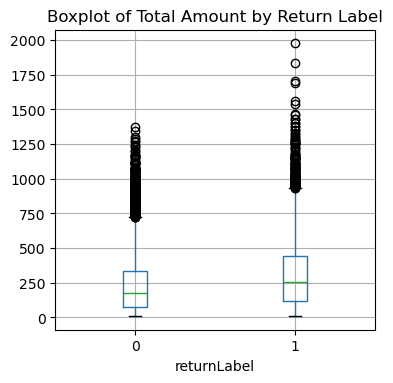

In [86]:
df_raw_transaction_data.boxplot(column='totalAmount', by='returnLabel', figsize=(4, 4))
plt.title('Boxplot of Total Amount by Return Label')
plt.suptitle('')
plt.show()

C:\Users\jakob\AppData\Roaming\Python\Python38\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


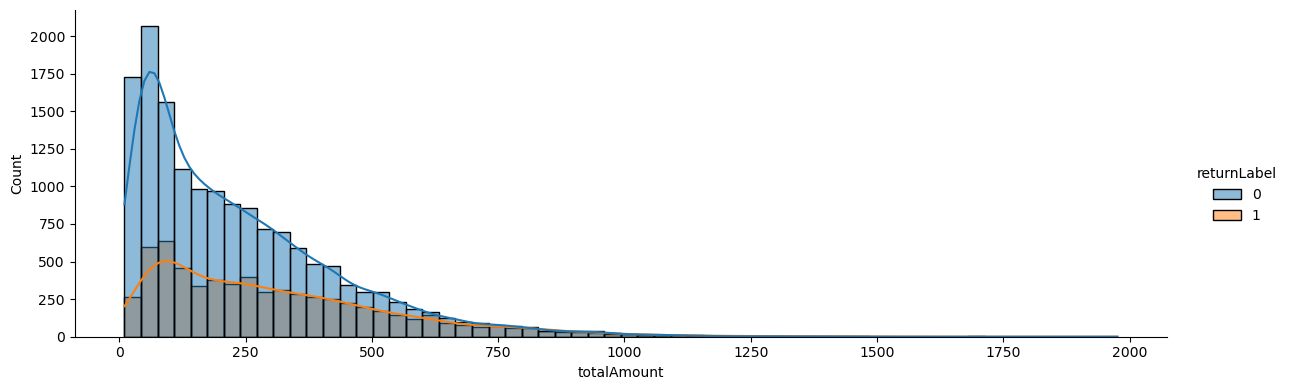

In [87]:
# %pip install seaborn
import seaborn as sns

sns.displot(df_raw_transaction_data, x='totalAmount', hue='returnLabel', bins=60, kde=True, height=4, aspect=3)
plt.show()

### 3 Fehlende Werte auffüllen

In [88]:
nan_values = df_raw_transaction_data.isna().sum()
print(nan_values)
nan_values = nan_values.sum()
print(f'Der Datensatz enthält {nan_values} NaN-Werte.')

transactionId      0
basket             0
customerType     442
totalAmount      477
returnLabel        0
dtype: int64
Der Datensatz enthält 919 NaN-Werte.


In [89]:
df_raw_transaction_data['totalAmount'].fillna(df_raw_transaction_data['totalAmount'].mean(), inplace=True)
df_raw_transaction_data['customerType'].fillna('unknown', inplace=True)

### 4 One-hot-encoding

In [90]:
df_transaction = pd.get_dummies(df_raw_transaction_data, columns=['customerType'])
df_transaction = df_transaction.drop(columns=['customerType_unknown'])

In [91]:
basket_matrix = pd.DataFrame(0, index=df_transaction.index, columns=[f'item_{i}' for i in range(6)])

for index, row in df_transaction.iterrows():
    basket = map(int, row['basket'][1:-1].split(','))
    for item in basket:
        basket_matrix.at[index, f'item_{item}'] += 1

df_final = pd.concat([df_transaction, basket_matrix], axis=1).drop(['basket', 'transactionId'], axis=1)

print(df_final.head())

   totalAmount  returnLabel  customerType_existing  customerType_new  item_0  item_1  item_2  item_3  item_4  item_5
0        252.0            1                  False              True       0       0       0       1       2       0
1         70.0            0                   True             False       1       0       2       0       1       1
2         84.0            0                   True             False       0       0       0       0       0       1
3        116.0            0                   True             False       0       1       1       0       2       0
4        378.0            0                   True             False       1       0       3       2       0       1


### 5 Features bauen

In [92]:
df_feature = df_final.assign(item_count_feature = df_final['item_0'] + df_final['item_1'] + df_final['item_2'] + df_final['item_3'] + df_final['item_4'] + df_final['item_5'])
df_feature = df_feature.assign(average_artikel_cost_feature = df_feature['totalAmount'] / df_feature['item_count_feature'])
print(df_feature.head())

   totalAmount  returnLabel  customerType_existing  customerType_new  item_0  item_1  item_2  item_3  item_4  item_5  item_count_feature  average_artikel_cost_feature
0        252.0            1                  False              True       0       0       0       1       2       0                   3                          84.0
1         70.0            0                   True             False       1       0       2       0       1       1                   5                          14.0
2         84.0            0                   True             False       0       0       0       0       0       1                   1                          84.0
3        116.0            0                   True             False       0       1       1       0       2       0                   4                          29.0
4        378.0            0                   True             False       1       0       3       2       0       1                   7                          54.

### --- cleanup

In [93]:
columns = [col for col in df_feature.columns if col != 'returnLabel']
columns.append('returnLabel')
df_feature = df_feature[columns]

df_feature.rename(columns={
    'totalAmount': 'total',
    'returnLabel': 'return',
    'customerType_existing': 'custExist',
    'customerType_new': 'custNew',
    'item_0': 'i0',
    'item_1': 'i1',
    'item_2': 'i2',
    'item_3': 'i3',
    'item_4': 'i4',
    'item_5': 'i5',
    'item_count_feature': 'count_f',
    'average_artikel_cost_feature': 'avgCost_f'
}, inplace=True)

print(df_feature.head())


   total  custExist  custNew  i0  i1  i2  i3  i4  i5  count_f  avgCost_f  return
0  252.0      False     True   0   0   0   1   2   0        3       84.0       1
1   70.0       True    False   1   0   2   0   1   1        5       14.0       0
2   84.0       True    False   0   0   0   0   0   1        1       84.0       0
3  116.0       True    False   0   1   1   0   2   0        4       29.0       0
4  378.0       True    False   1   0   3   2   0   1        7       54.0       0


### 6 Skalieren

In [ ]:
from sklearn.preprocessing import StandardScaler

numeric_columns = ['total', 'i0', 'i1', 'i2', 'i3', 'i4', 'i5', 'count_f', 'avgCost_f']
df_skaliert = df_feature.copy()
df_skaliert[numeric_columns] = StandardScaler().fit_transform(df_skaliert[numeric_columns])

print(df_skaliert.head())

      total  custExist  custNew        i0        i1        i2        i3        i4        i5   count_f  avgCost_f  return
0 -0.032823      False     True -0.771563 -0.767737 -0.775046  0.075189  0.634586 -0.644106 -0.607275   0.856494       1
1 -0.879459       True    False  0.383487 -0.767737  1.514422 -0.880132 -0.122402  0.527090  0.133204  -1.343755       0
2 -0.814334       True    False -0.771563 -0.767737 -0.775046 -0.880132 -0.879391  0.527090 -1.347754   0.856494       0
3 -0.665475       True    False -0.771563  0.391580  0.369688 -0.880132  0.634586 -0.644106 -0.237036  -0.872273       0
4  0.553309       True    False  0.383487 -0.767737  2.659156  1.030510 -0.879391  0.527090  0.873682  -0.086470       0


### 7. Klassifikationsmodelle Trainieren

In [95]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

X_train = df_skaliert.drop(columns=["return"])
y_train = df_skaliert["return"]

grid_params = {
    "Logistic Regression": (LogisticRegression(solver='liblinear'), {"C": [0.1, 1, 4, 5, 6, 10, 30, 100], "penalty": ["l1", "l2"]}),
    "Random Forest": (RandomForestClassifier(), {"n_estimators": [60, 80, 100, 120, 140], "max_depth": [2, 4, 6]}),
    "Gradient Boosting Tree": (GradientBoostingClassifier(), {"n_estimators": [60, 80, 100, 120, 140], "max_depth": [2, 4, 6]})
}

grid_search_results = {}

# Training
for name, (model, params) in grid_params.items():
    print(f"\nTraining {name}...")
    grid_search = GridSearchCV(model, params, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    grid_search_results[name] = grid_search  # Speichern des Ergebnisses
    print(f"Best parameters for {name}: {grid_search.best_params_}")


Training Logistic Regression...
Best parameters for Logistic Regression: {'C': 1, 'penalty': 'l2'}

Training Random Forest...
Best parameters for Random Forest: {'max_depth': 6, 'n_estimators': 100}

Training Gradient Boosting Tree...
Best parameters for Gradient Boosting Tree: {'max_depth': 2, 'n_estimators': 140}


### ---visulation

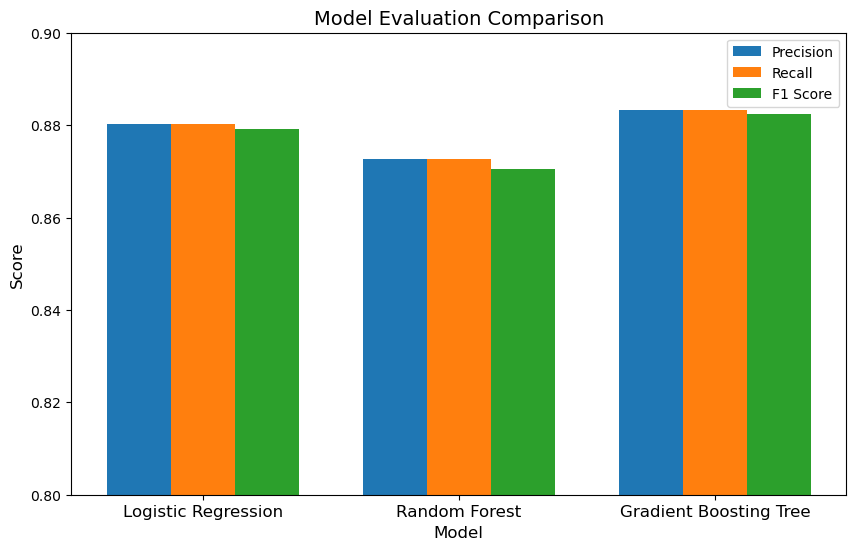

In [96]:
import numpy as np
from sklearn.metrics import classification_report

# Ergebnisse der Grid Search für jedes Modell
models = list(grid_search_results.keys())
precision = []
recall = []
f1_score = []

# Evaluation der Modelle und Extrahierung der Metriken
for name, grid_search in grid_search_results.items():
    y_pred = grid_search.best_estimator_.predict(X_train)
    report = classification_report(y_train, y_pred, output_dict=True)  # Klassifikationsbericht als Dictionary
    precision.append(report['accuracy'])  # Oder spezifische Metriken wie Precision, Recall, F1-Score
    recall.append(report['weighted avg']['recall'])
    f1_score.append(report['weighted avg']['f1-score'])

# Balkendiagramm erstellen
bar_width = 0.25
index = np.arange(len(models))

# Platzierung der Balken
fig, ax = plt.subplots(figsize=(10, 6))

bar1 = ax.bar(index, precision, bar_width, label='Precision')
bar2 = ax.bar(index + bar_width, recall, bar_width, label='Recall')
bar3 = ax.bar(index + 2 * bar_width, f1_score, bar_width, label='F1 Score')

# Achsen und Labels
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Evaluation Comparison', fontsize=14)
ax.set_xticks(index + bar_width)
ax.set_xticklabels(models, fontsize=12)
ax.legend()

ax.set_ylim(0.8, 0.9)

# Diagramm anzeigen
plt.show()


### 8. Laden der Testdaten

In [97]:
df_raw_transaction_test_data = pd.read_csv(r"data/test.csv", delimiter=';')

### 9. Entfernen Sie alle Zeilen mit fehlenden Werten.

In [98]:
df_raw_transaction_test_data.dropna(inplace=True)

### 10. Transformieren Sie die Attribute genauso wie bei den Trainingsdaten.

In [99]:
# one-hot encoding
df_transaction_test = pd.get_dummies(df_raw_transaction_test_data, columns=['customerType'])
basket_matrix = pd.DataFrame(0, index=df_transaction_test.index, columns=[f'item_{i}' for i in range(6)])
for index, row in df_transaction_test.iterrows():
    basket = map(int, row['basket'][1:-1].split(','))
    for item in basket:
        basket_matrix.at[index, f'item_{item}'] += 1
df_final_test = pd.concat([df_transaction_test, basket_matrix], axis=1).drop(['basket', 'transactionId'], axis=1)

# feature hinzufügen
df_feature_test = df_final_test.assign(item_count_feature = df_final_test['item_0'] + df_final_test['item_1'] + df_final_test['item_2'] + df_final_test['item_3'] + df_final_test['item_4'] + df_final_test['item_5'])
df_feature_test = df_feature_test.assign(average_artikel_cost_feature = df_feature_test['totalAmount'] / df_feature_test['item_count_feature'])

#cleanup
columns = [col for col in df_feature_test.columns if col != 'returnLabel']
columns.append('returnLabel')
df_feature_test = df_feature_test[columns]
df_feature_test.rename(columns={
    'totalAmount': 'total',
    'returnLabel': 'return',
    'customerType_existing': 'custExist',
    'customerType_new': 'custNew',
    'item_0': 'i0',
    'item_1': 'i1',
    'item_2': 'i2',
    'item_3': 'i3',
    'item_4': 'i4',
    'item_5': 'i5',
    'item_count_feature': 'count_f',
    'average_artikel_cost_feature': 'avgCost_f'
}, inplace=True)


### 11. Skalieren Sie die Daten im gleichem Maß wie die Trainingsdaten.

In [113]:
df_skaliert_test = df_feature_test.copy()
df_skaliert_test[numeric_columns] = StandardScaler().fit_transform(df_skaliert_test[numeric_columns])

### 12. Machen Sie eine Vorhersage auf den Testdaten mit allen drei Modellen und den jeweils besten Hyperparametern aus der Cross Validation.

In [115]:
# verstehe ich noch nicht richtig was gemeint ist

In [117]:
X_test = df_skaliert_test.drop(columns=["return"])
y_test = df_skaliert_test["return"]

predictions = {}
for name, grid_search in grid_search_results.items():
    predictions[name] = grid_search.best_estimator_.predict(X_test)


### 13. Berechnen Sie für jedes der drei Modell Accuracy, Precision und Recall.

In [159]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

metrics = {}
for model_name, prediction in predictions.items():
    metrics[model_name] = {
        'accuracy': accuracy_score(y_test, prediction),
        'precision': precision_score(y_test, prediction),
        'recall': recall_score(y_test, prediction)
    }

for model_name, metric in metrics.items():
    print(f"{model_name:<25}Accuracy: {round(metric['accuracy'], 4)}    Precision: {round(metric['precision'], 4)}    Recall: {round(metric['recall'], 4)}")

Logistic Regression      Accuracy: 0.8772    Precision: 0.8131    Recall: 0.7643
Random Forest            Accuracy: 0.8612    Precision: 0.7998    Recall: 0.7135
Gradient Boosting Tree   Accuracy: 0.8752    Precision: 0.8067    Recall: 0.7654


### 14. Berechnen Sie außerdem die Accuracy auf den Trainingsdaten und vergleichen Sie Accuracy auf Trainings- und Testdaten. Liegt Overfitting vor? (Unterschied > 5%)

In [158]:
# Calculate accuracy on training data
train_accuracies = {}
for name, grid_search in grid_search_results.items():
    y_train_pred = grid_search.best_estimator_.predict(X_train)
    train_accuracies[name] = accuracy_score(y_train, y_train_pred)

# Compare accuracies
for model_name, train_accuracy in train_accuracies.items():
    test_accuracy = metrics[model_name]['accuracy']
    diff = abs(train_accuracy - test_accuracy)
    overfitting = "Yes" if diff > 0.05 else "No"
    print(f"{model_name:<25} Train Accuracy: {train_accuracy:.4f}    Test Accuracy: {test_accuracy:.4f}    Overfitting: {overfitting}")



Logistic Regression       Train Accuracy: 0.8803    Test Accuracy: 0.8772    Overfitting: No
Random Forest             Train Accuracy: 0.8726    Test Accuracy: 0.8612    Overfitting: No
Gradient Boosting Tree    Train Accuracy: 0.8833    Test Accuracy: 0.8752    Overfitting: No


###  15. Untersuchen Sie wieviele Datenpunkte es in den Testdaten gibt, welche von allen drei Modellen falsch klassifiziert wurden: 
1. Bestimmen Sie für jedes der drei Modelle die Indizes der Testdatenpunkte auf welchen das jeweilige Modell falsch klassifiziert hat. 
2. Nutzen Sie die set-Klasse in Python um die Anzahl an Datenpunkten zu bestimmen, welche von allen drei Modellen falsch klassifiziert wurden.

In [160]:
misclassified_indices = {}
for model_name, prediction in predictions.items():
    misclassified_indices[model_name] = set(df_feature_test.index[y_test != prediction])

common_misclassified_indices = set.intersection(*misclassified_indices.values())

print(f"Number of data points misclassified by all three models: {len(common_misclassified_indices)}")

Number of data points misclassified by all three models: 895


### 16. Vergleichen Sie die Feature-Importances der drei Modelle.

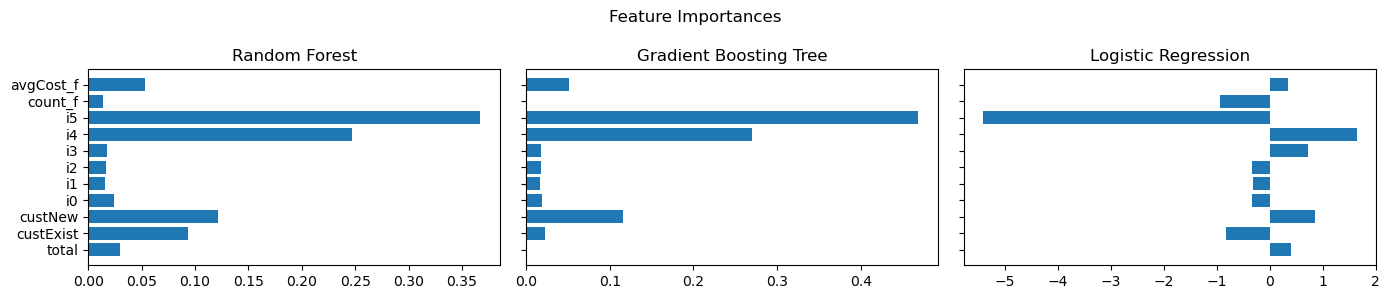

In [110]:
# Extract feature importances
feature_importances = {
    "Random Forest": grid_search_results["Random Forest"].best_estimator_.feature_importances_,
    "Gradient Boosting Tree": grid_search_results["Gradient Boosting Tree"].best_estimator_.feature_importances_
}

# Logistic Regression does not have feature importances, but we can use the coefficients instead
log_reg_coefficients = grid_search_results["Logistic Regression"].best_estimator_.coef_[0]
feature_importances["Logistic Regression"] = log_reg_coefficients

# Plot feature importances
fig, axes = plt.subplots(1, 3, figsize=(14, 3), sharey=True)
fig.suptitle('Feature Importances')

for ax, (model_name, importances) in zip(axes, feature_importances.items()):
    ax.barh(X_train.columns, importances)
    ax.set_title(model_name)

plt.tight_layout()
plt.show()